<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install finta
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
SID = '^DJI'
df = web.DataReader(SID,'yahoo',start="1980-01-01")#,end="2019-09-10")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(8724, 5)


,High,Low,Open,Close,Volume
Date,,,,,
1985-01-29,1295.489990,1266.890015,1277.719971,1292.619995,13560000
1985-01-30,1305.099976,1278.930054,1297.369995,1287.880005,16820000
1985-01-31,1293.400024,1272.640015,1283.239990,1286.770020,14070000


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

In [6]:
ret = triple_barrier(df.Close, 1.05 , 0.95 ,20)['triple_barrier_signal'] #未來20個交易日,漲跌5%
df = df.join(ret)
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2019-08-12,26178.949219,25824.939453,26169.910156,25896.439453,199390000,0
2019-08-13,26426.970703,25833.250000,25888.880859,26279.910156,308900000,0
2019-08-14,26035.080078,25471.589844,26035.080078,25479.419922,352250000,0
2019-08-15,25639.689453,25339.599609,25514.250000,25579.390625,332600000,0
2019-08-16,25929.650391,25678.169922,25678.169922,25886.009766,276210000,0
2019-08-19,26222.320312,26020.060547,26020.060547,26135.789062,252640000,0
2019-08-20,26160.119141,25952.000000,26086.859375,25962.439453,238100000,0
2019-08-21,26268.320312,26141.769531,26145.359375,26202.730469,208790000,0
2019-08-22,26388.779297,26099.009766,26271.640625,26252.240234,222810000,0


# 觀察最近100天的labels

(24510.43512101267, 28101.172535237332)

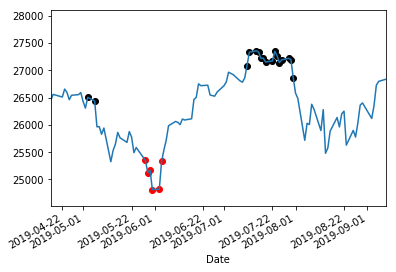

In [7]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][-100:].plot()
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
lb = df['Close'][-100:].mean() - 3*df['Close'][-100:].std()
ub = df['Close'][-100:].mean() + 3*df['Close'][-100:].std()
plt.ylim(lb,ub)

# 檢查Labels是否平衡

 0    6148
 1    1399
-1    1177
Name: triple_barrier_signal, dtype: int64


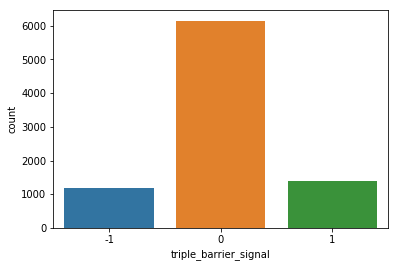

In [8]:
g = sns.countplot(df['triple_barrier_signal'])
print(df['triple_barrier_signal'].value_counts())

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    8723.000000
mean       54.821153
std        16.196020
min         0.000000
25%        43.355705
50%        55.729747
75%        66.853812
max        94.741933
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304


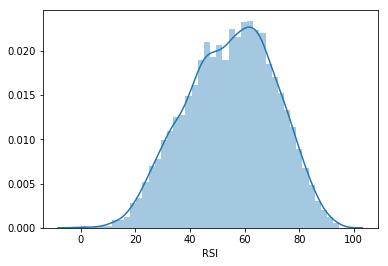

In [10]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    8711.000000
mean      -39.657801
std        29.970462
min      -100.000000
25%       -64.948569
50%       -33.926557
75%       -12.370509
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994


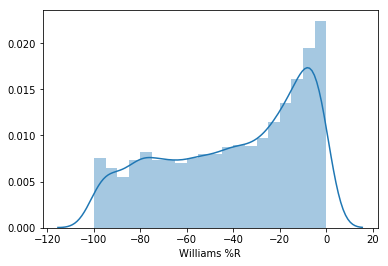

In [11]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count     8684.000000
mean      9650.721234
std       6238.768536
min       1261.914643
25%       3606.284698
50%      10014.999428
75%      12506.702684
max      26759.521103
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772


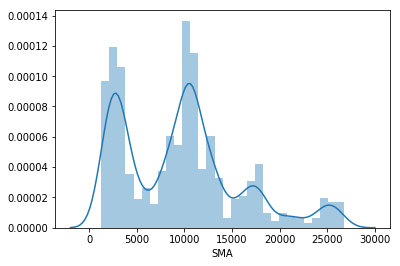

In [12]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count     8724.000000
mean      9658.145814
std       6283.844209
min       1253.483551
25%       3593.941321
50%       9948.293189
75%      12528.358227
max      27201.667593
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256


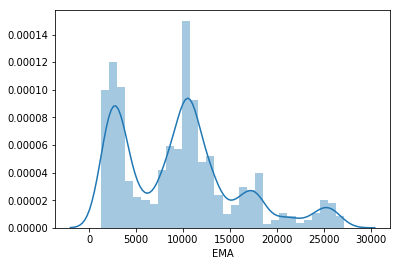

In [13]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count     8716.000000
mean      9661.930569
std       6279.692920
min       1248.968245
25%       3605.209623
50%       9939.339616
75%      12543.678825
max      27283.239106
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988


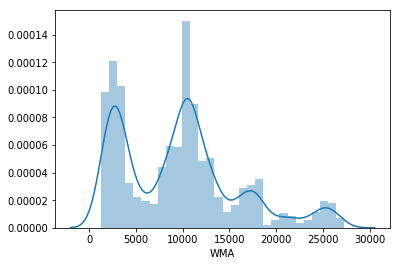

In [14]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count     8721.000000
mean      9666.724228
std       6288.087230
min       1243.728027
25%       3600.223999
50%       9926.556934
75%      12552.030762
max      27329.670898
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563


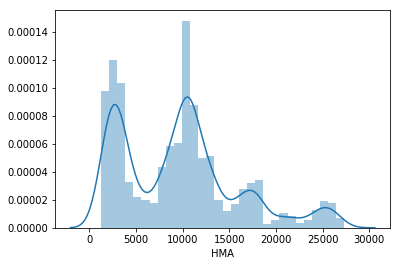

In [15]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count     8724.000000
mean      9669.622608
std       6293.621392
min       1243.116150
25%       3597.679928
50%       9929.640445
75%      12553.336547
max      27357.214328
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353


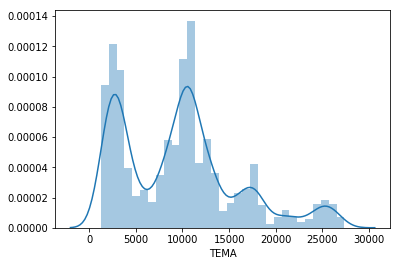

In [16]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    8723.000000
mean       20.524360
std        86.342976
min      -249.934749
25%       -47.826792
50%        38.650893
75%        90.711304
max       218.608626
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694


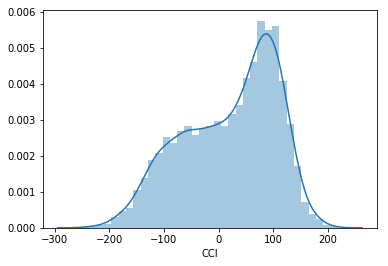

In [17]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    8715.000000
mean       10.309793
std        40.742608
min       -98.714787
25%       -19.493128
50%        10.948328
75%        40.073733
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362


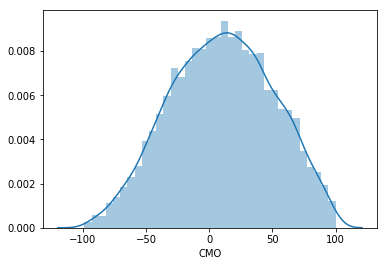

In [18]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    8724.000000
mean       -0.028840
std        34.877388
min      -296.962685
25%       -12.949790
50%         0.124748
75%        12.846856
max       197.671782
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015


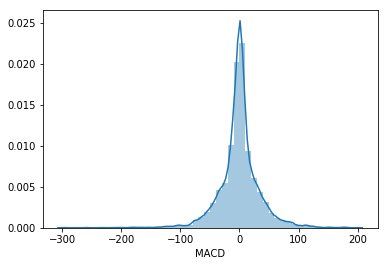

In [19]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    8724.000000
mean       -0.000105
std         0.336025
min        -3.335306
25%        -0.184529
50%        -0.001048
75%         0.181988
max         1.780877
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934,0.229633
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880,0.267822
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177,0.373548
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855,0.440987
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015,0.472270


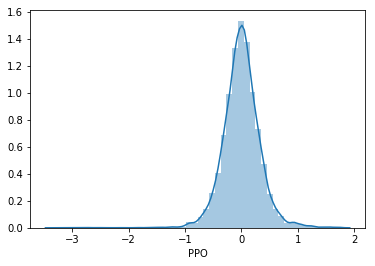

In [20]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    8712.000000
mean        0.474927
std         3.379756
min       -34.118671
25%        -1.227405
50%         0.709761
75%         2.398953
max        18.371026
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934,0.229633,2.105714
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880,0.267822,1.813570
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177,0.373548,2.266476
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855,0.440987,3.216267
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015,0.472270,2.414936


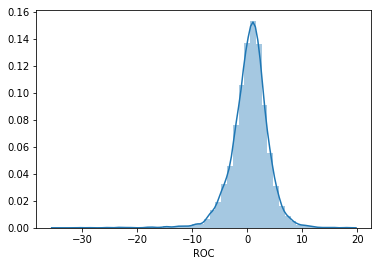

In [21]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    8.715000e+03
mean     3.224230e+10
std      3.481536e+11
min     -1.347586e+12
25%     -1.501156e+11
50%      2.567482e+10
75%      2.020499e+11
max      2.044159e+12
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934,0.229633,2.105714,-3.568509e+10
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880,0.267822,1.813570,-2.256791e+10
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177,0.373548,2.266476,5.556285e+09
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855,0.440987,3.216267,3.120961e+10
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015,0.472270,2.414936,5.408813e+10


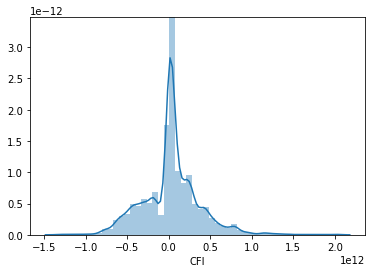

In [22]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    8641.000000
mean        0.470780
std        21.363427
min      -177.248390
25%       -10.619508
50%         3.185766
75%        13.829386
max        85.997003
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934,0.229633,2.105714,-3.568509e+10,-7.304729
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880,0.267822,1.813570,-2.256791e+10,0.910737
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177,0.373548,2.266476,5.556285e+09,21.844727
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855,0.440987,3.216267,3.120961e+10,20.026862
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015,0.472270,2.414936,5.408813e+10,19.159603


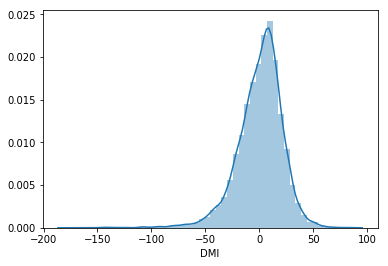

In [23]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count     8724.000000
mean      9621.305010
std       6268.074003
min       1161.110656
25%       3575.729948
50%       9861.807188
75%      12521.420166
max      27398.679688
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-03,26198.259766,25978.220703,26198.259766,26118.019531,223210000,0,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934,0.229633,2.105714,-3.568509e+10,-7.304729,25629.315708
2019-09-04,26362.349609,26244.439453,26301.990234,26355.470703,202710000,0,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880,0.267822,1.813570,-2.256791e+10,0.910737,25700.139983
2019-09-05,26836.300781,26603.150391,26603.150391,26728.150391,256670000,0,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177,0.373548,2.266476,5.556285e+09,21.844727,25765.298315
2019-09-06,26860.869141,26708.390625,26790.250000,26797.460938,209700000,0,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855,0.440987,3.216267,3.120961e+10,20.026862,25872.398562
2019-09-09,26900.830078,26762.179688,26866.230469,26835.509766,273120000,0,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015,0.472270,2.414936,5.408813e+10,19.159603,25991.015031


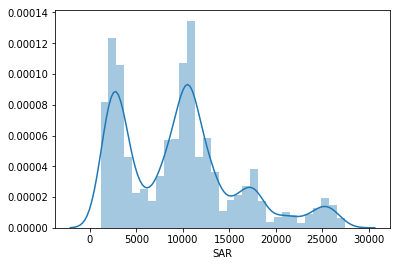

In [24]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [25]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(8724, 21)
(8641, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-03,50.090507,-33.752597,26535.558927,26112.680916,26037.400174,26215.572656,26260.282746,23.391411,7.025077,60.468934,0.229633,2.105714,-3.568509e+10,-7.304729,25629.315708,0
2019-09-04,56.502074,-13.544323,26524.566978,26161.238873,26015.364974,26325.034766,26341.688531,77.973636,6.905702,70.398880,0.267822,1.813570,-2.256791e+10,0.910737,25700.139983,0
2019-09-05,64.711665,-8.136985,26523.217226,26274.621177,25994.003602,26340.626758,26569.991790,151.211344,18.773808,98.061177,0.373548,2.266476,5.556285e+09,21.844727,25765.298315,0
2019-09-06,66.085243,-4.684103,26521.687024,26379.189129,26123.278212,26379.225195,26741.742832,141.049882,58.990220,115.803855,0.440987,3.216267,3.120961e+10,20.026862,25872.398562,0
2019-09-09,66.901304,-4.686994,26515.526772,26470.453256,26219.381988,26603.676563,26859.075353,129.258694,53.553362,124.140015,0.472270,2.414936,5.408813e+10,19.159603,25991.015031,0


# 相關性分析

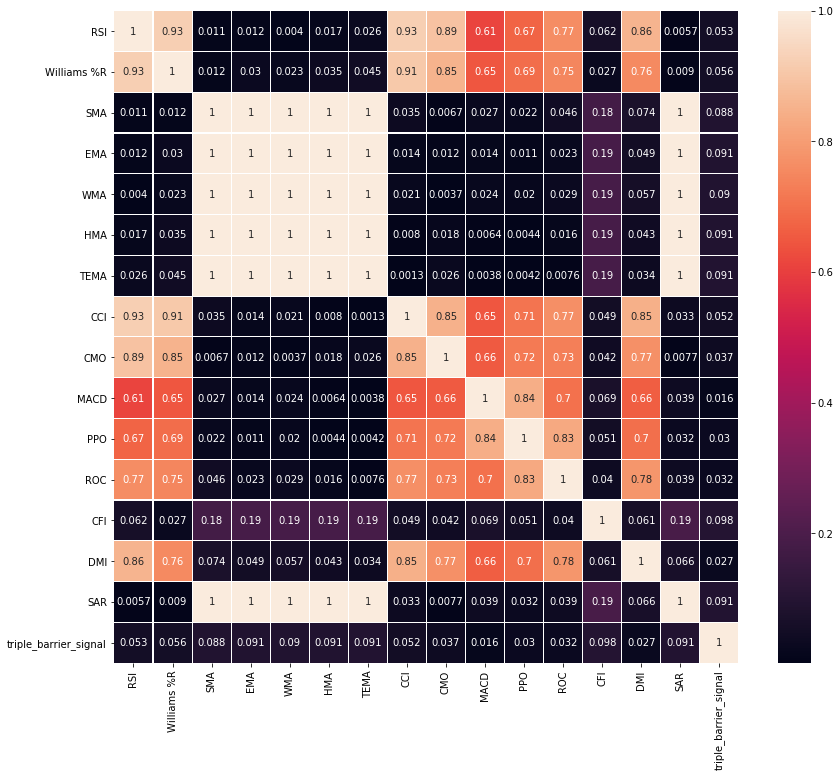

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [27]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-03,0.501027,0.662474,0.991213,0.957963,0.952061,0.957205,0.957909,0.583353,0.532119,0.722618,0.696797,0.690124,0.386792,0.645571,0.932247,0
2019-09-04,0.572675,0.864557,0.990782,0.959838,0.951213,0.961409,0.961032,0.699846,0.531518,0.742693,0.704261,0.684558,0.390660,0.676780,0.934959,0
2019-09-05,0.664416,0.918630,0.990729,0.964214,0.950391,0.962008,0.969793,0.856156,0.591242,0.798618,0.724926,0.693186,0.398952,0.756302,0.937454,0
2019-09-06,0.679766,0.953159,0.990669,0.968251,0.955365,0.963491,0.976383,0.834468,0.793625,0.834488,0.738108,0.711281,0.406515,0.749397,0.941555,0
2019-09-09,0.688885,0.953130,0.990427,0.971774,0.959063,0.972113,0.980885,0.809303,0.766265,0.851341,0.744222,0.696015,0.413260,0.746102,0.946097,0


In [28]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [29]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 8627/8627 [00:17<00:00, 498.38it/s]


準備完成


# check

In [30]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 8627
第一筆的index開始和結束:1985-05-29-1985-06-18
最後一筆的index開始和結束:2019-08-19-2019-09-09


# Reshape X

(圖片數量,長,寬,1張)

In [31]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(8627, 15, 15)
(8627, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [32]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(8627, 1)
[[0]
 [0]
 [0]
 [0]
 [0]]


Using TensorFlow backend.


(8627, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# Visualization

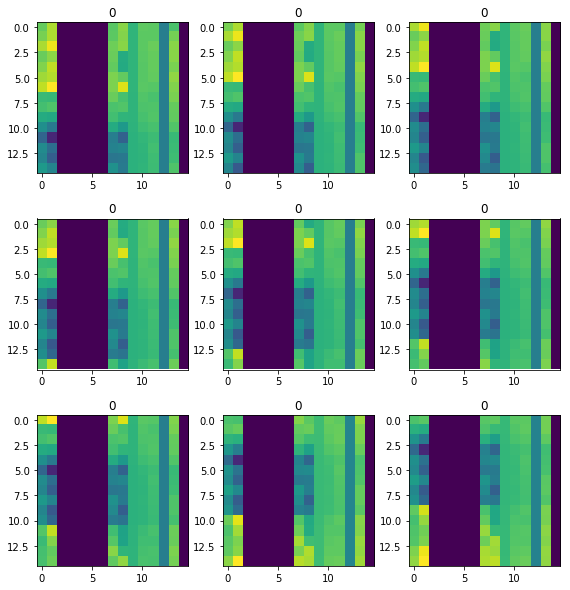

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [34]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練資料(裡面再去拆分成訓練跟驗證)
print(X_train.shape,y_train.shape,X_test.shape)

(8587, 15, 15, 1) (8587, 3) (40, 15, 15, 1)


# 對訓練資料調整採樣使其數據平衡

轉換shape才能丟到RandomOverSampler

In [35]:
X_train2維 = X_train.reshape(X_train.shape[0],-1)
y_train數字 = np.array([ np.argmax(i) for i in y_train])
print(X_train2維.shape)
print(y_train數字.shape)

(8587, 225)
(8587,)


丟到RandomOverSampler

In [36]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler()
ros = RandomUnderSampler()
X_train平衡 ,y_train平衡 = ros.fit_sample(X_train2維 ,y_train數字)
print(pd.DataFrame(y_train平衡)[0].value_counts().sort_index())#顯示結果

0    1164
1    1164
2    1164
Name: 0, dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


轉換回原本shape

In [37]:
X_train = X_train平衡.reshape(X_train平衡.shape[0],15,15,1)#資料數,15,15,1
y_train = y_train平衡.reshape(y_train平衡.shape[0],1)#資料數,1
y_train = to_categorical(y_train , num_classes = 3)#one_hot
print(X_train.shape)
print(y_train.shape)

(3492, 15, 15, 1)
(3492, 3)


In [38]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size = 0.3,#7,3分
                                              random_state = 42,
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2444, 15, 15, 1) (2444, 3) (1048, 15, 15, 1) (1048, 3)


# 看一下樣本的label分布情況是否平均(已解決)

0:Hold,1:Buy,2:Sell

In [39]:
pd.Series([np.argmax(i) for i in y_train]).value_counts()

1    1164
2    1164
0    1164
dtype: int64

In [40]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

1    841
2    824
0    779
dtype: int64

In [41]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

0    385
2    340
1    323
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [43]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))#15,15,32
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))#15,15,64
model.add(MaxPool2D(pool_size=(5,5)))# 3,3,64
model.add(Flatten())#576
model.add(Dropout(0.5))#288
model.add(Dense(128, activation='relu'))#128
model.add(Dropout(0.5))#64
model.add(Dense(32, activation='relu'))#32
model.add(Dropout(0.5))#16
model.add(Dense(nclasses, activation='softmax'))#3
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               73856     


In [44]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=50,  
                   mode='max',
                   restore_best_weights = True)#恢復最佳權重

# fit

In [46]:
history = model.fit(xtrain,ytrain,
                    batch_size = 128,
                    epochs = 500,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2444 samples, validate on 1048 samples
Epoch 1/500
2444/2444 [==============================] - 3s 1ms/step - loss: 1.1048 - acc: 0.3290 - val_loss: 1.0973 - val_acc: 0.3244
Epoch 2/500
2444/2444 [==============================] - 0s 66us/step - loss: 1.0991 - acc: 0.3527 - val_loss: 1.0966 - val_acc: 0.4027
Epoch 3/500
2444/2444 [==============================] - 0s 58us/step - loss: 1.0974 - acc: 0.3457 - val_loss: 1.0962 - val_acc: 0.3321
Epoch 4/500
2444/2444 [==============================] - 0s 57us/step - loss: 1.0962 - acc: 0.3478 - val_loss: 1.0944 - val_acc: 0.3721
Epoch 5/500
2444/2444 [==============================] - 0s 58us/step - loss: 1.0933 - acc: 0.3719 - val_loss: 1.0916 - val_acc: 0.3807
Epoch 6/500
2444/2444 [==============================] - 0s 56us/step - loss: 1.0947 - acc: 0.3752 - val_loss: 1.0930 - val_acc: 0.3569
Epoch 7/500
2444/2444 [====================

# 訓練過程評估

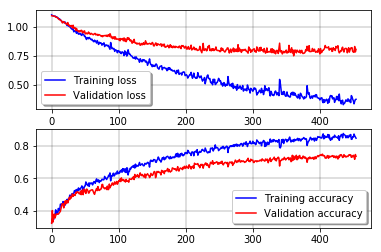

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

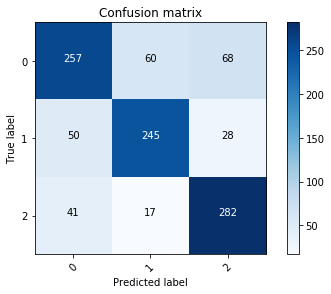

In [48]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [49]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


真實y值

In [50]:
print(yval[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


# 分類報告

In [51]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.74      0.67      0.70       385
         BUY       0.76      0.76      0.76       323
        SELL       0.75      0.83      0.79       340

   micro avg       0.75      0.75      0.75      1048
   macro avg       0.75      0.75      0.75      1048
weighted avg       0.75      0.75      0.75      1048
 samples avg       0.75      0.75      0.75      1048



# plot error

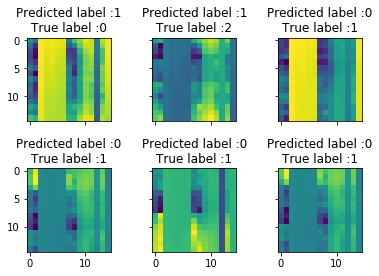

In [52]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

# model預測最近40筆

In [53]:
answer = model.predict(X_test)#model預測買賣信號
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 看看最近一百天預測結果

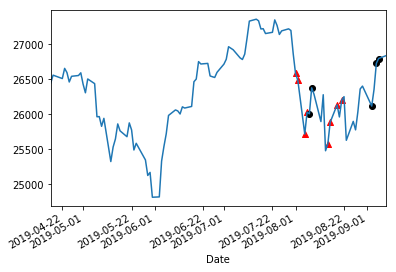

In [54]:
INDEX100 = df[-100:].index#取最最近100天INDEX
C = web.DataReader(SID,'yahoo',start="1980-01-01")[['Close']]#取得歷史收盤價
C = C.loc[INDEX100,:]#最近100天收盤價
C['SIGNAL'] = [np.nan for _ in range(60)] + answer # 買賣信號:前60個NAN+40個預測答案
buy = C[C['SIGNAL']==1]['Close']#買點
sell = C[C['SIGNAL']==2]['Close']#賣點
C['Close'].plot()#畫線
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")#畫買點
plt.scatter(list(sell.index),list(sell.values),color='black')#畫賣點

# 最近40天預測結果

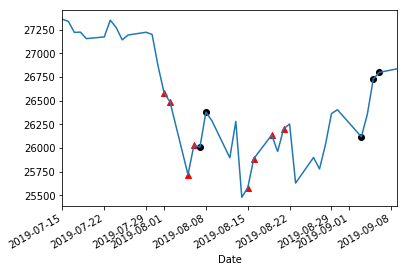

In [55]:
C['Close'][-40:].plot()#畫線
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")#畫買點
plt.scatter(list(sell.index),list(sell.values),color='black')#畫賣點